In [1]:
import os
import warnings

import astropy.coordinates as coord
from astropy.io.fits.column import VerifyWarning
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.ndimage import gaussian_filter

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
from helpers import make_cmd, get_MG_BPRP

# Shut up, FITS!
warnings.filterwarnings('ignore', category=VerifyWarning)

In [13]:
# run_name = '150pc_MG12-result'
# run_name = '400pc-cube-result'
run_name = 'clump-200pc-cube'
t = at.Table.read(f'../cache/probs-{run_name}.fits')
d = at.Table.read(f'../data/{run_name}.fits')
joined = at.join(d, t, keys='source_id', join_type='left')

g = GaiaData(joined[joined['prob'] > 0.5])
nong = GaiaData(joined[joined['prob'] < 0.5])
nong = nong[nong.get_ruwe() < 1.4]

ruwe = g.get_ruwe()

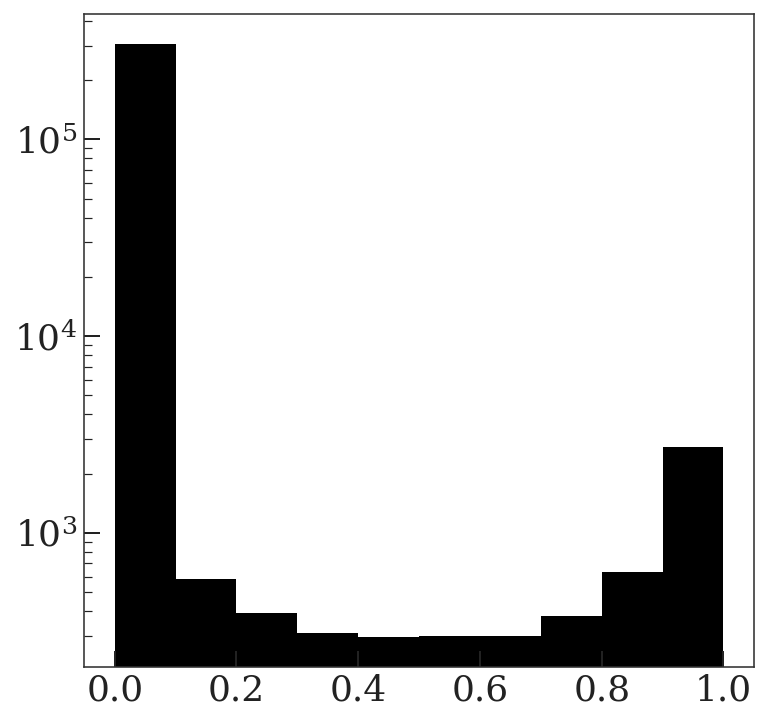

In [14]:
plt.hist(joined['prob'])
plt.yscale('log')

In [15]:
len(g), len(nong)

(4347, 246460)

In [23]:
c = g.get_skycoord()
gal = c.galactic

In [24]:
mg, bprp = get_MG_BPRP(g, dust_correct=False)

In [25]:
# bperr = 1.086 * g.phot_bp_mean_flux_error / g.phot_bp_mean_flux
# rperr = 1.086 * g.phot_rp_mean_flux_error / g.phot_rp_mean_flux
# gerr = 1.086 * g.phot_g_mean_flux_error / g.phot_g_mean_flux

# distmod_samples = g.get_error_samples(size=16_384)
# distmod_err = np.std(distmod_samples.distmod, axis=1)
# mgerr = np.sqrt(gerr**2 + distmod_err.value**2)
# bprperr = np.sqrt(bperr**2 + rperr**2)

In [26]:
# for fr in [coord.BarycentricMeanEcliptic(), coord.Galactic(), coord.ICRS()]:
#     fig = plt.figure(figsize=(7, 6))
#     plt.scatter(highprob_c.transform_to(fr).spherical.lon.degree,
#                 highprob_c.transform_to(fr).spherical.lat.degree,
#                 alpha=0.5, lw=0)
#     plt.xlim(360, 0)
#     plt.ylim(-90, 90)
#     plt.xlabel('lon')
#     plt.ylabel('lat')
#     plt.title(fr.name)
#     plt.tight_layout()
#     fig.set_facecolor('w')

Color-magnitude diagrams with isochrones:

/mnt/home/apricewhelan/.local/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


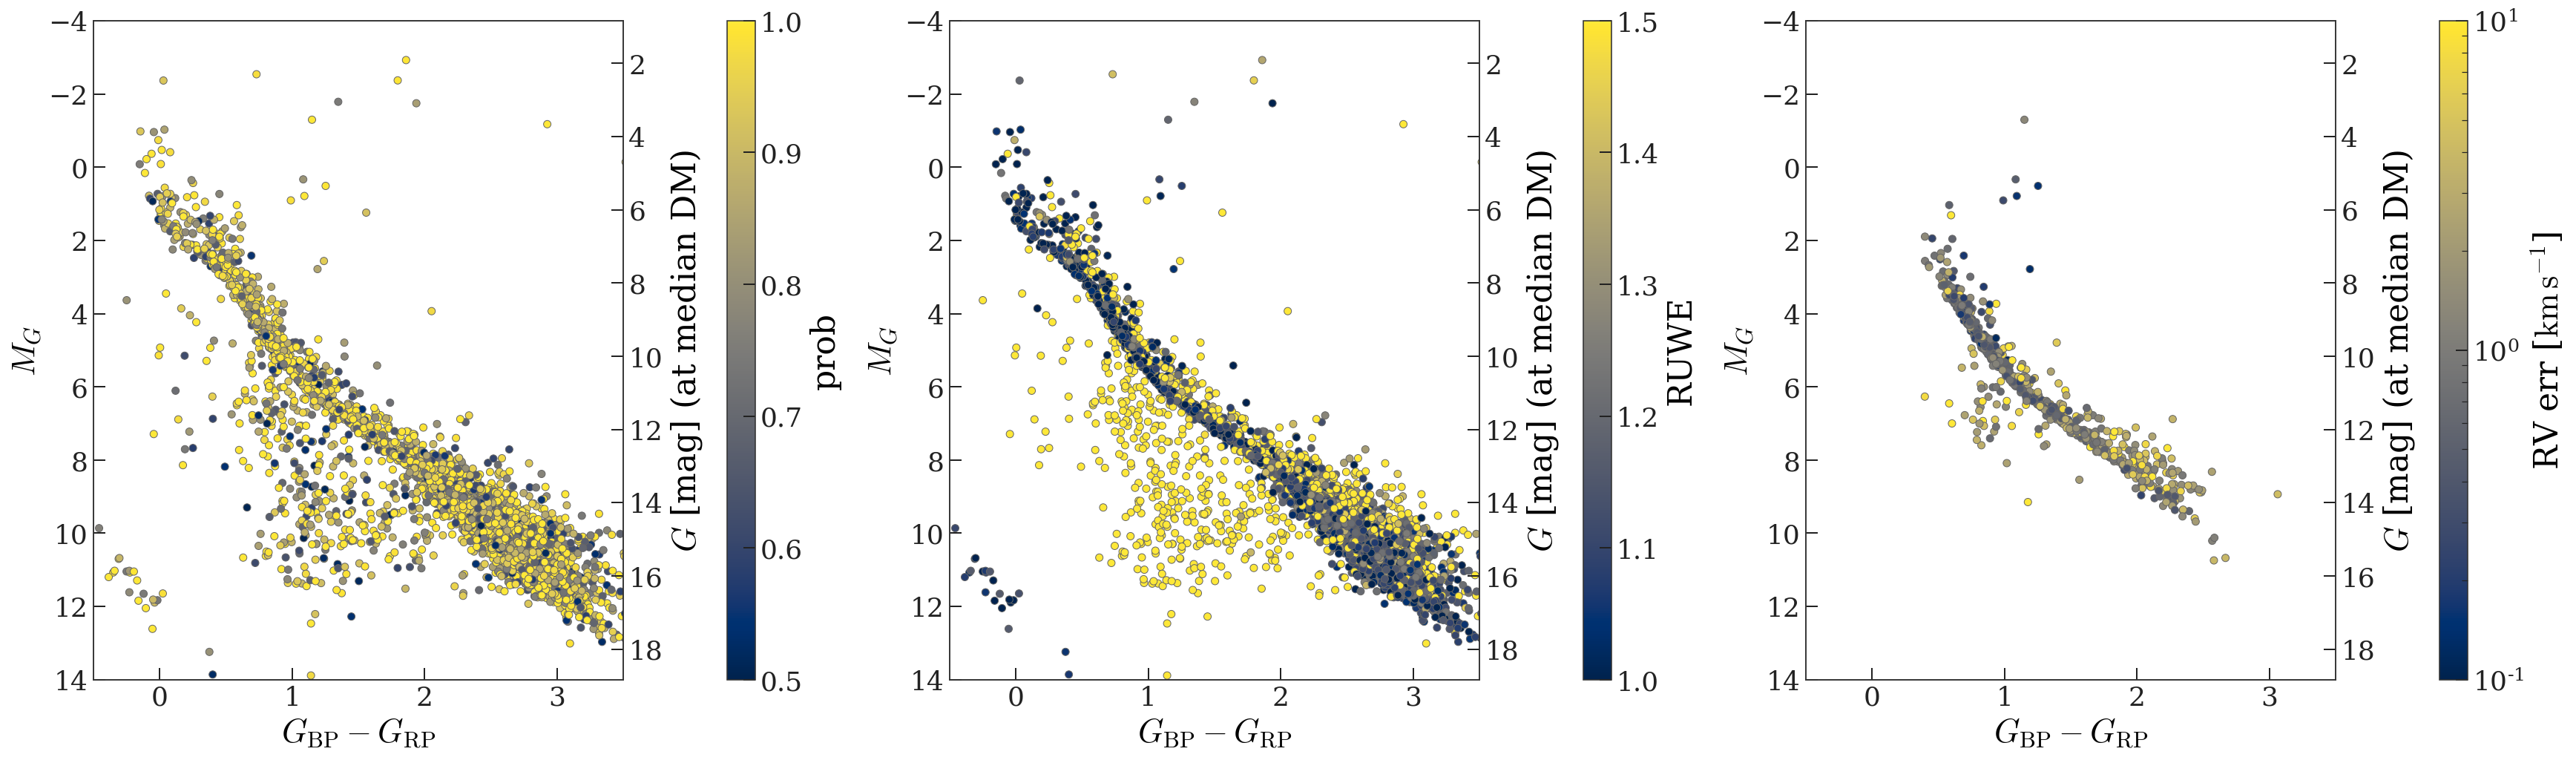

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), 
                         constrained_layout=True)

_ = make_cmd(g, 
             c=g.prob,
             norm=mpl.colors.Normalize(vmin=0.5, vmax=1),
             cbar_label='prob',
             ax=axes[0])

_ = make_cmd(g,
             c=ruwe,
             norm=mpl.colors.Normalize(vmin=1, vmax=1.5),
             cbar_label='RUWE',
             ax=axes[1])

_ = make_cmd(g,
             c=g.radial_velocity_error.value,
             norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1),
             cbar_label=f'RV err [{u.km/u.s:latex_inline}]',
             ax=axes[2])

In [39]:
clean_g = g[(ruwe < 1.4)]

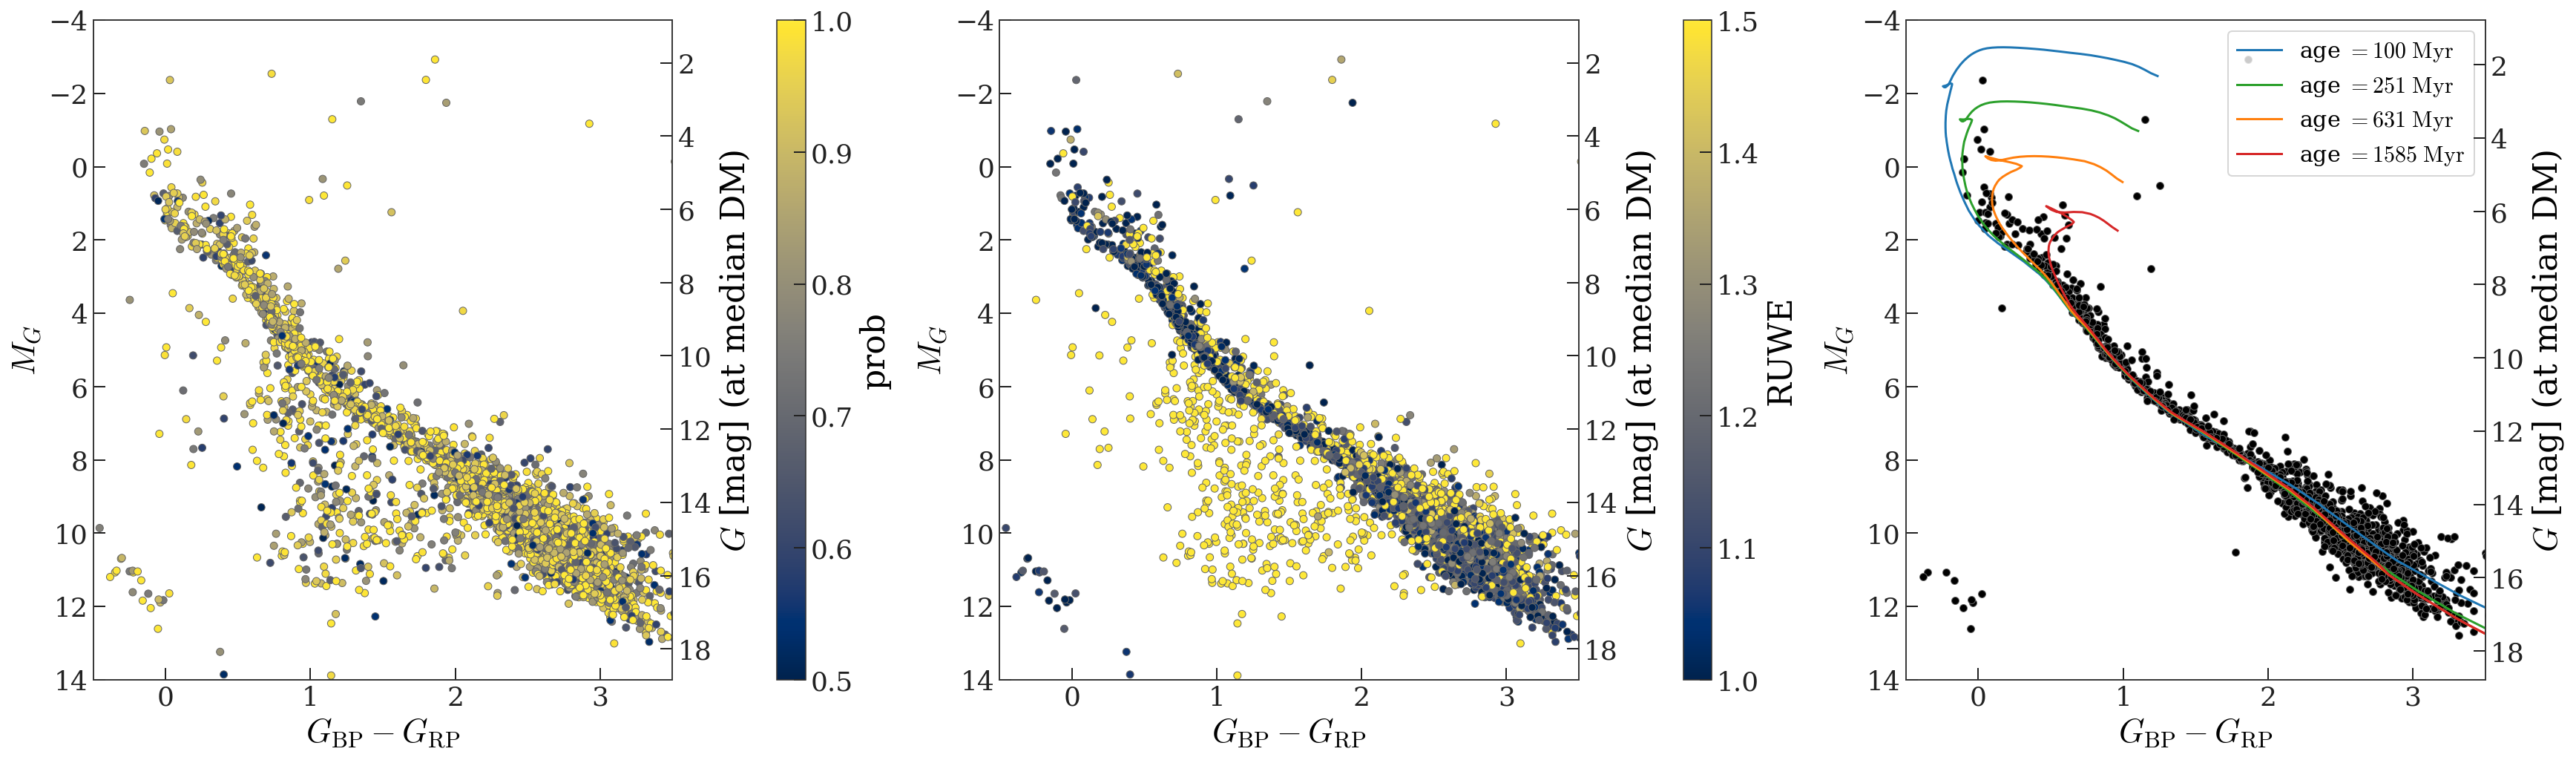

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), 
                         constrained_layout=True)

_ = make_cmd(g, 
             c=g.prob,
             norm=mpl.colors.Normalize(vmin=0.5, vmax=1),
             cbar_label='prob',
             ax=axes[0])

_ = make_cmd(g,
             c=ruwe,
             norm=mpl.colors.Normalize(vmin=1, vmax=1.5),
             cbar_label='RUWE',
             ax=axes[1])


_ = make_cmd(clean_g, dust_correct=True, ax=axes[2])

ax = axes[2]
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
for j, age in enumerate(np.arange(8., 9.2+1e-3, 0.4)):
    iso = at.Table.read(os.path.expanduser(f'~/data/isochrones/PARSEC/FeH_0.1_iso.fits'))
    i = iso[np.isclose(iso['log(age/yr)'], age)] 
    i = i[i['stage'] < 3]  # rgb or before
    age = 10**age / 1e6
    ax.plot(i['G_BP']-i['G_RP'], i['G'], marker='', label=f'age $={age:.0f}' + r'~{\rm Myr}$', color=colors[j])
ax.legend(loc='upper right', fontsize=15)

### Spatial distribution

In [40]:
labels = ['x', 'y', 'z']

In [41]:
clean_mg, clean_bprp = get_MG_BPRP(clean_g)
highlight_mask = np.isin(clean_g.source_id, 
                         [1490845584382687232,
                          1476485996883837184]) # OG pair!

clean_c = clean_g.get_skycoord()
og_x = np.mean(clean_c[highlight_mask].data.without_differentials())

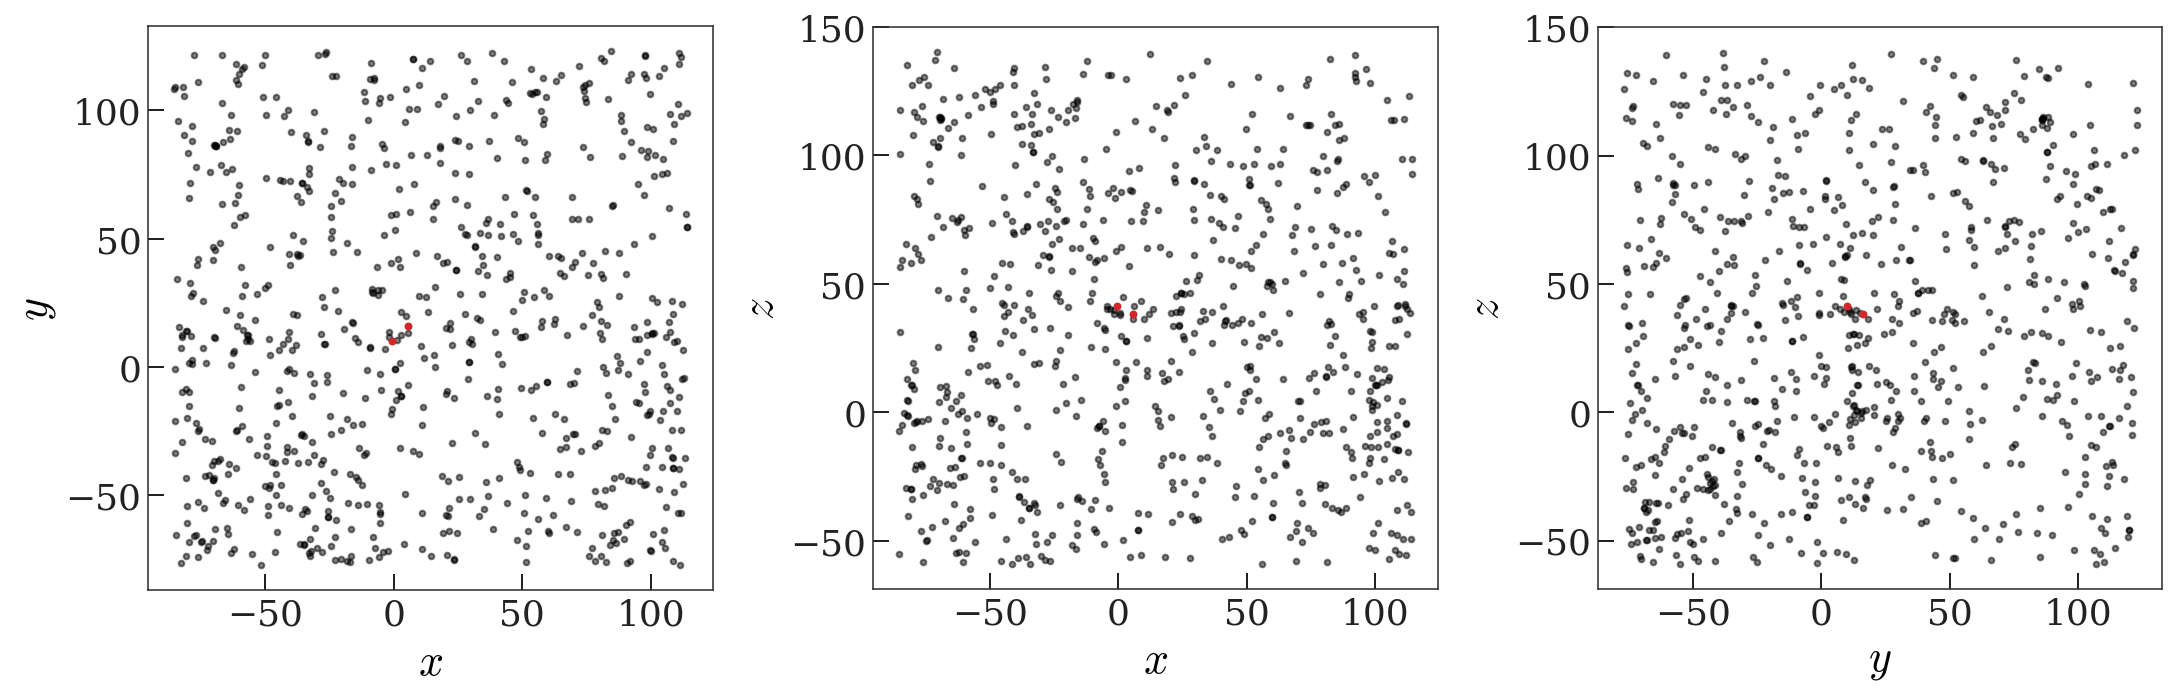

In [42]:
this_gal = clean_c.galactic
xyz = this_gal.cartesian.xyz.to_value(u.pc)

dx = (clean_c.data.without_differentials() - og_x).norm()
near_pair_mask = dx < 50*u.pc
far_pair_mask = dx > 75*u.pc

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         constrained_layout=True)

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    cs = ax.scatter(xyz[i][clean_mg < 8*u.mag], 
                    xyz[j][clean_mg < 8*u.mag],
                    marker='o', s=8, alpha=0.5)
    cs = ax.scatter(xyz[i][highlight_mask], 
                    xyz[j][highlight_mask],
                    marker='o', s=8, alpha=1., color='tab:red')
    
#     cs = ax.scatter(xyz[i][clustered_mask], xyz[j][clustered_mask], 
#                     color='tab:red', marker='o', s=8, alpha=0.5)
    
#     H, xe, ye = np.histogram2d(
#         xyz[i], xyz[j],
#         bins=(np.arange(xyz[i].min(), xyz[i].max(), 2),
#               np.arange(xyz[j].min(), xyz[j].max(), 2)))
#     ax.pcolormesh(xe, ye, gaussian_filter(H.T, sigma=2))

    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
    ax.set_aspect('equal')
    
# fig.colorbar(cs, ax=axes)

fig.set_facecolor('w')

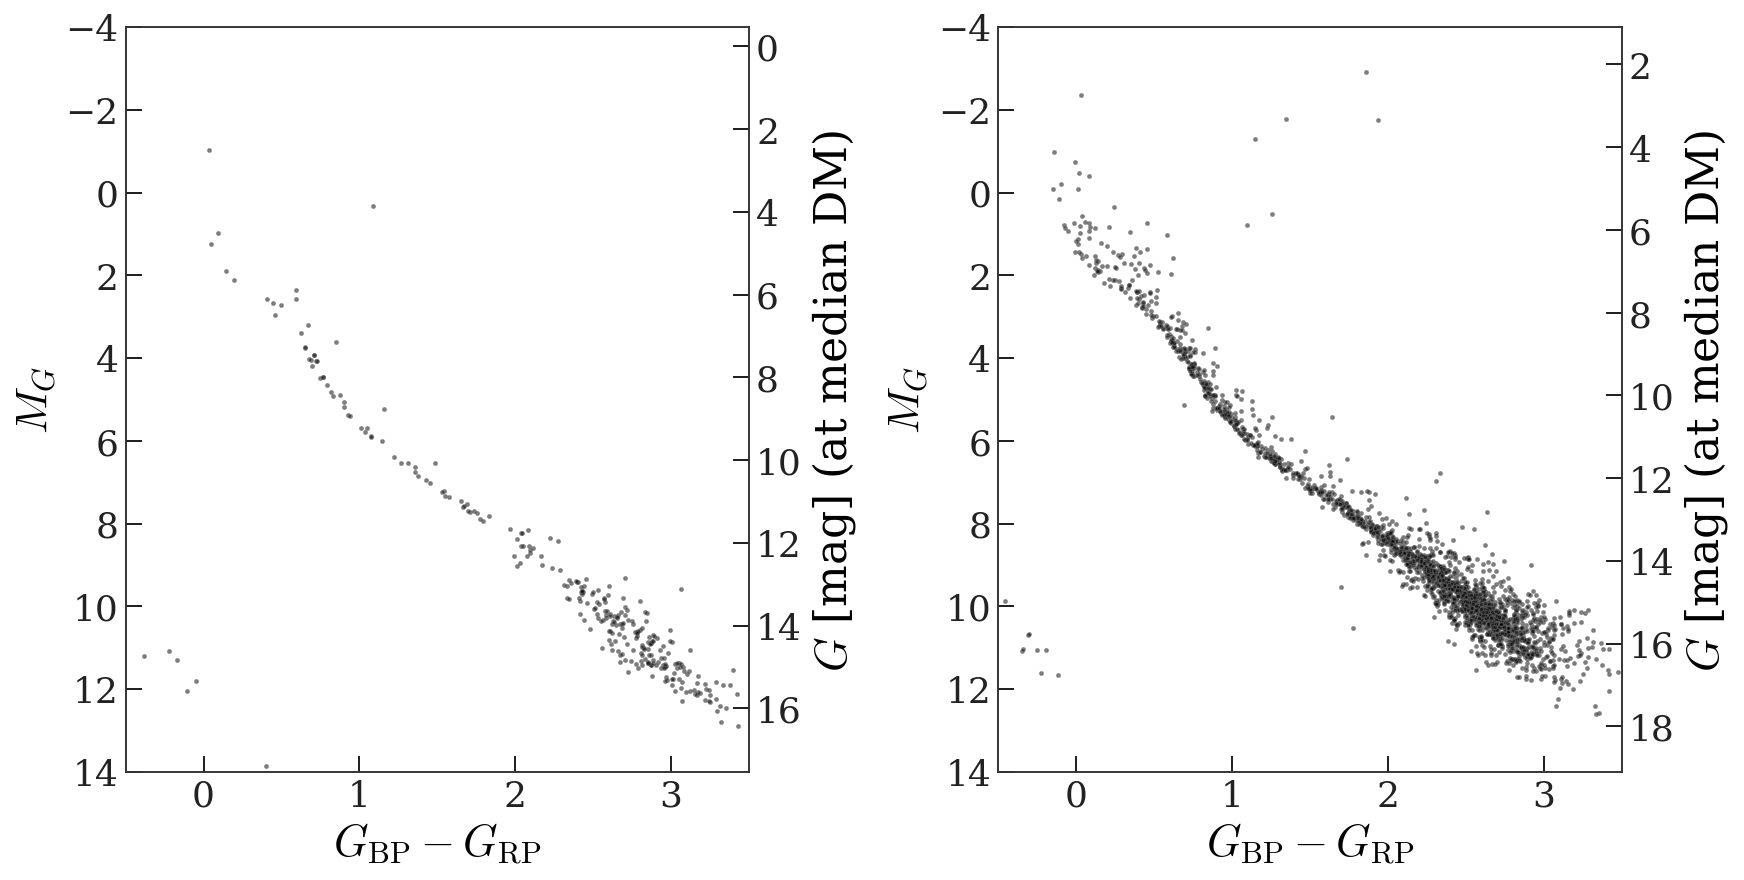

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         constrained_layout=True)
_ = make_cmd(clean_g[near_pair_mask], ax=axes[0], alpha=0.5, s=4)
_ = make_cmd(clean_g[far_pair_mask], ax=axes[1], alpha=0.5, s=4)

### Compare CMD to a random down-sampling of all stars:

In [44]:
len(nong), len(clean_g)

(246460, 3066)

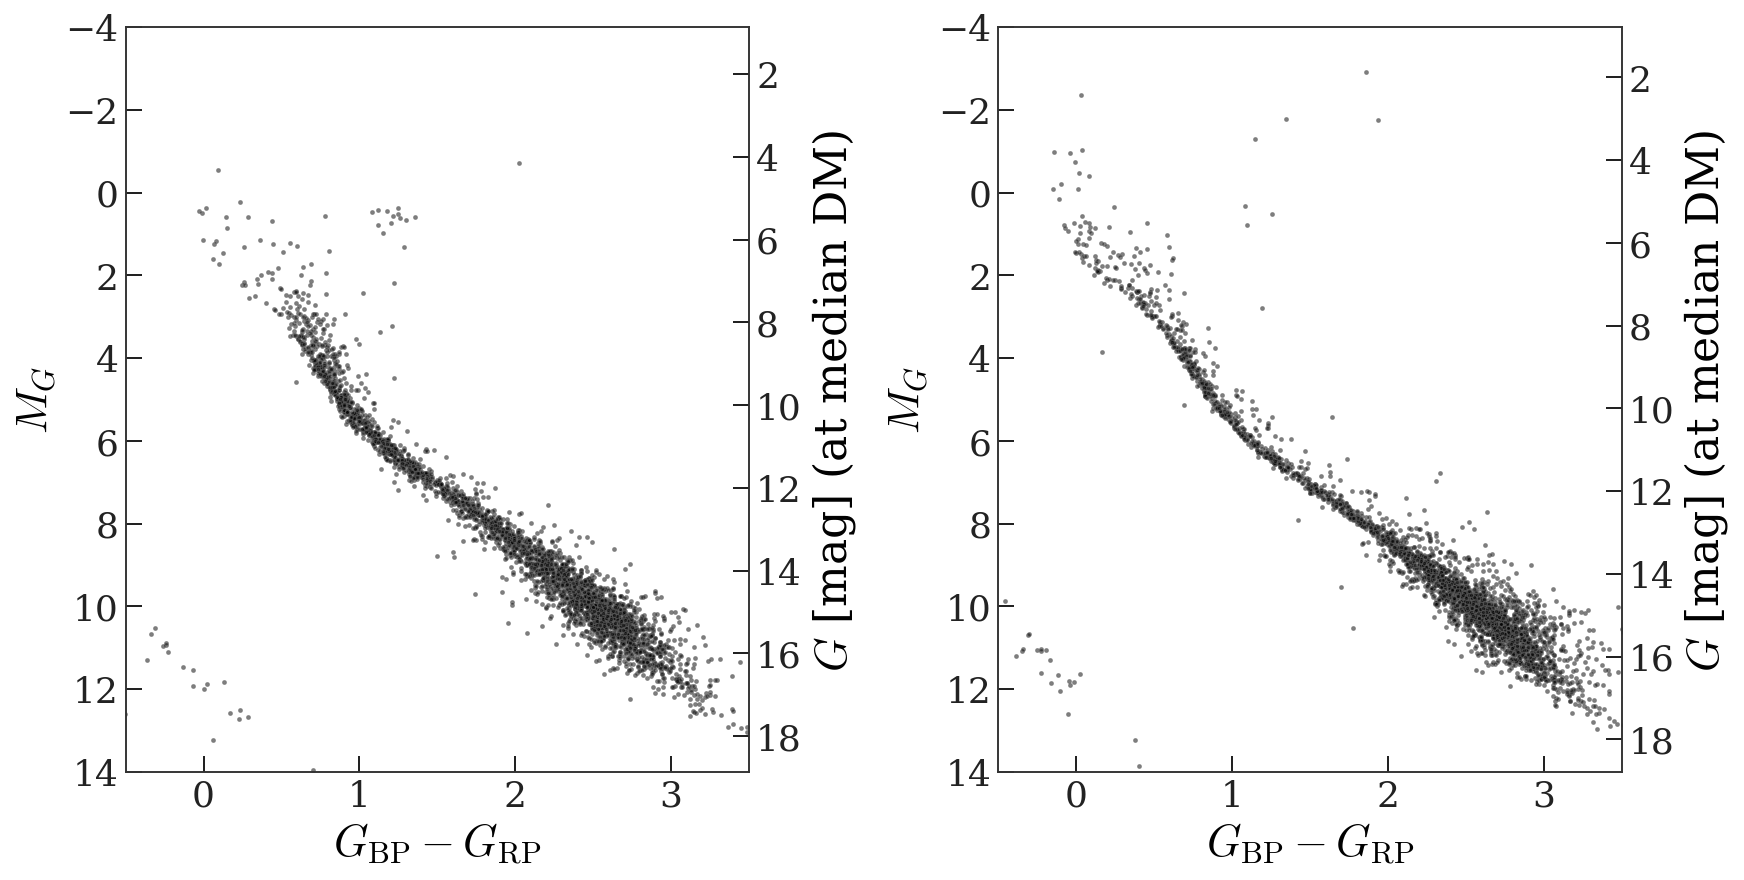

In [45]:
fac = len(nong) // len(clean_g)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         constrained_layout=True)
_ = make_cmd(nong[::fac], ax=axes[0], alpha=0.5, s=4)
_ = make_cmd(clean_g, ax=axes[1], alpha=0.5, s=4)

In [47]:
strict_mask = ((clean_g.prob > 0.95) & 
               np.isfinite(clean_g.radial_velocity) &
               ((clean_g.phot_g_mean_mag - clean_g.distmod) < 8*u.mag) &
               near_pair_mask)

In [52]:
the_best = clean_g[strict_mask]

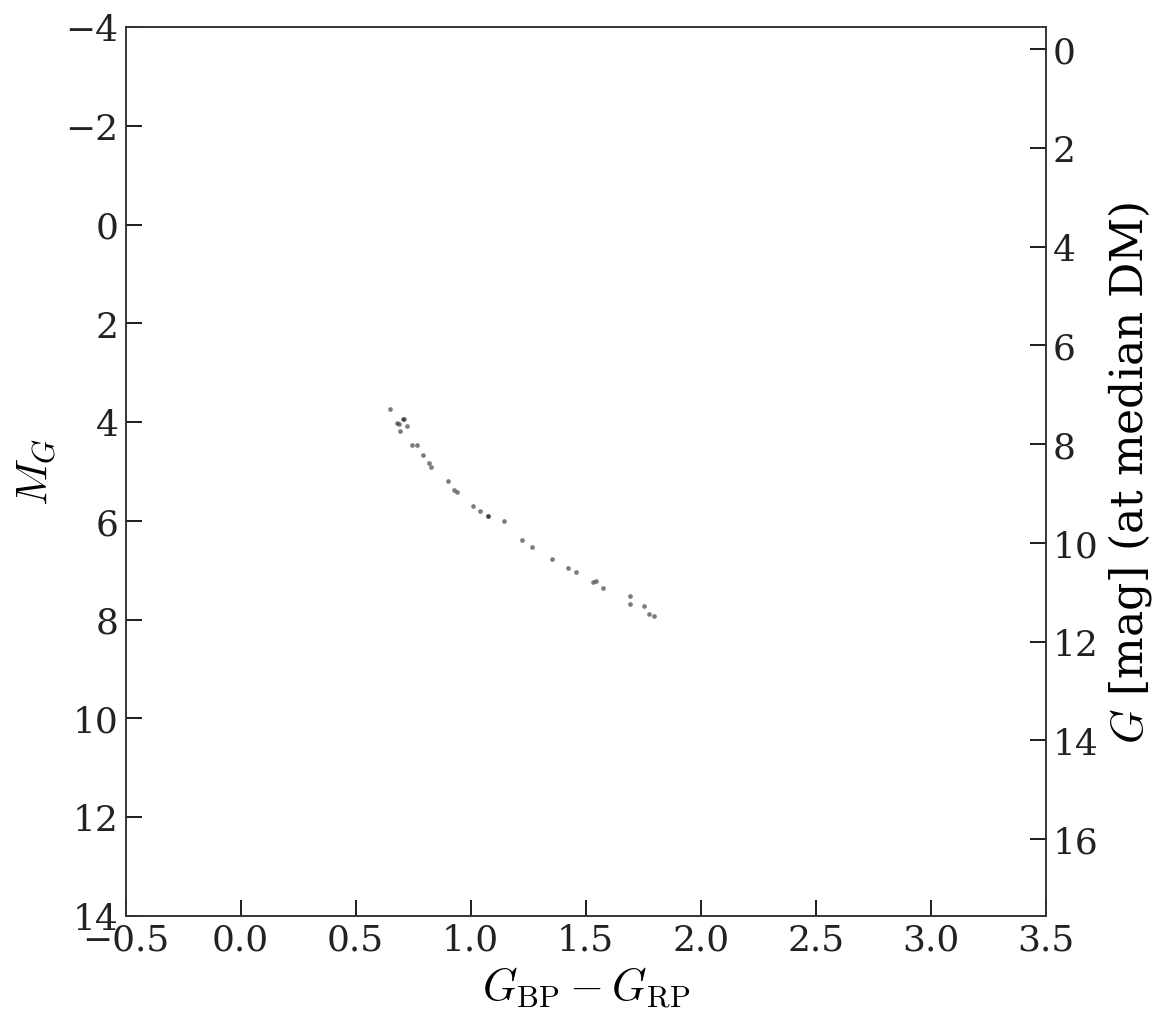

In [53]:
_ = make_cmd(the_best, alpha=0.5, s=4)

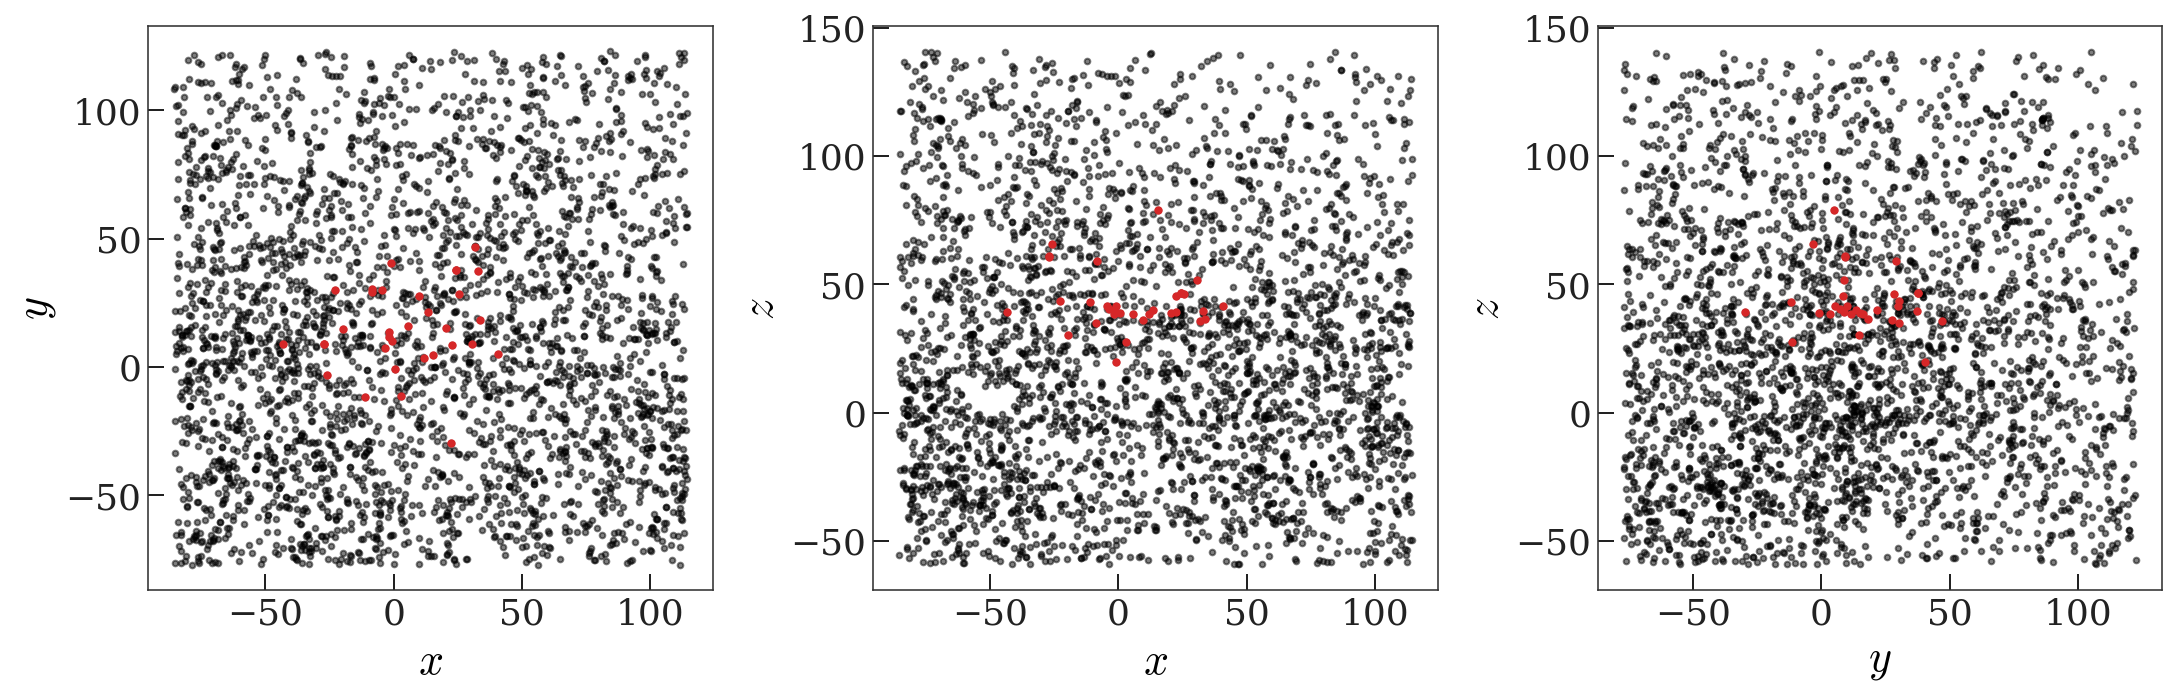

In [56]:
clean_gal = clean_g.get_skycoord().galactic

labels = ['x', 'y', 'z']

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         constrained_layout=True)

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.scatter(clean_gal.cartesian.xyz.to_value(u.pc)[i],
               clean_gal.cartesian.xyz.to_value(u.pc)[j],
               marker='o', s=8, alpha=0.5)
    
    ax.scatter(clean_gal.cartesian.xyz.to_value(u.pc)[i][strict_mask],
               clean_gal.cartesian.xyz.to_value(u.pc)[j][strict_mask],
               marker='o', s=10, alpha=1, color='tab:red')

    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
    ax.set_aspect('equal')

fig.set_facecolor('w')

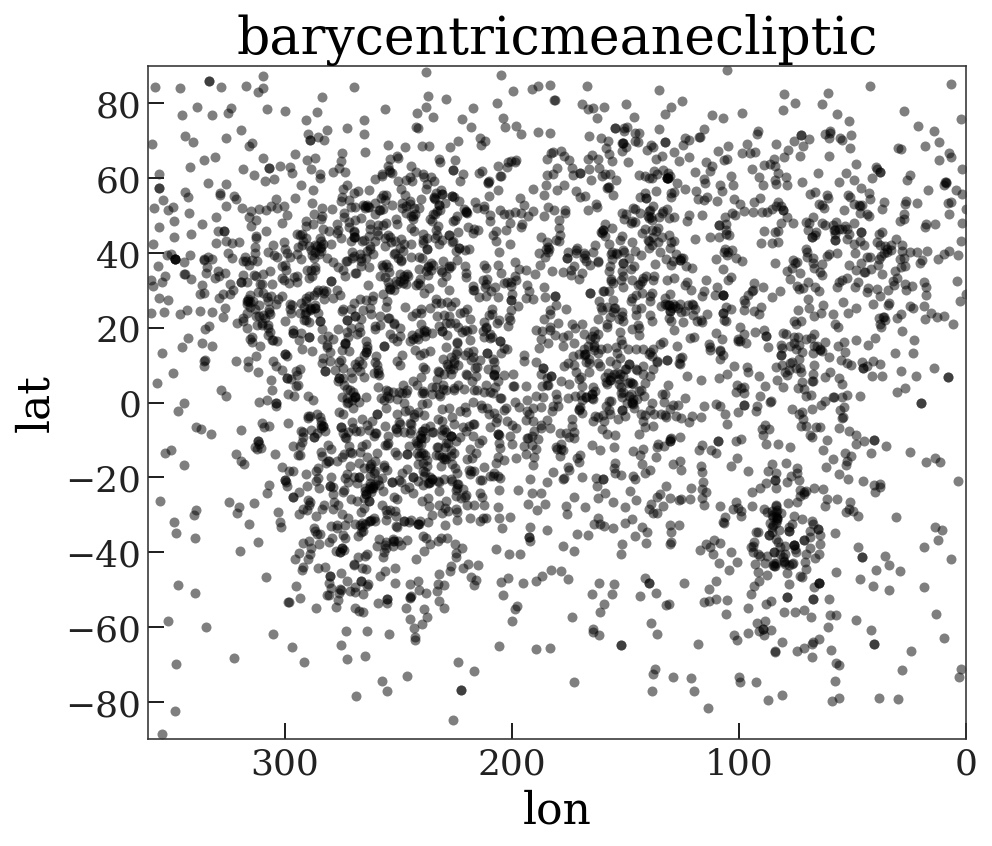

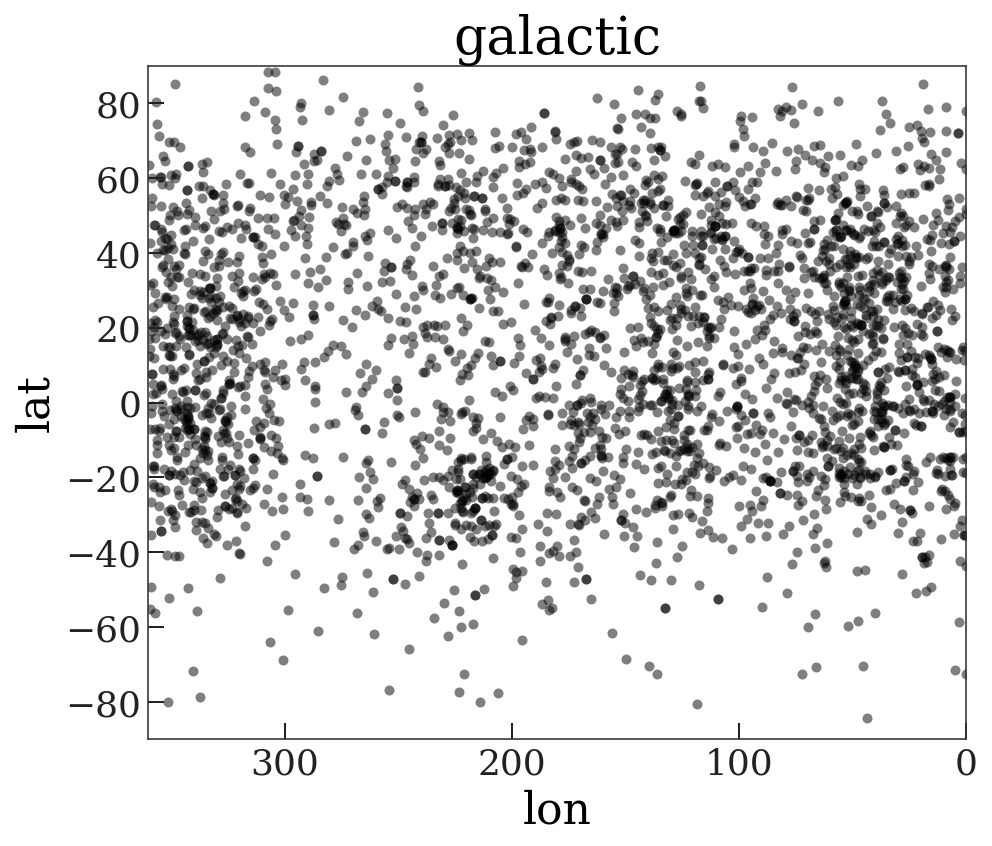

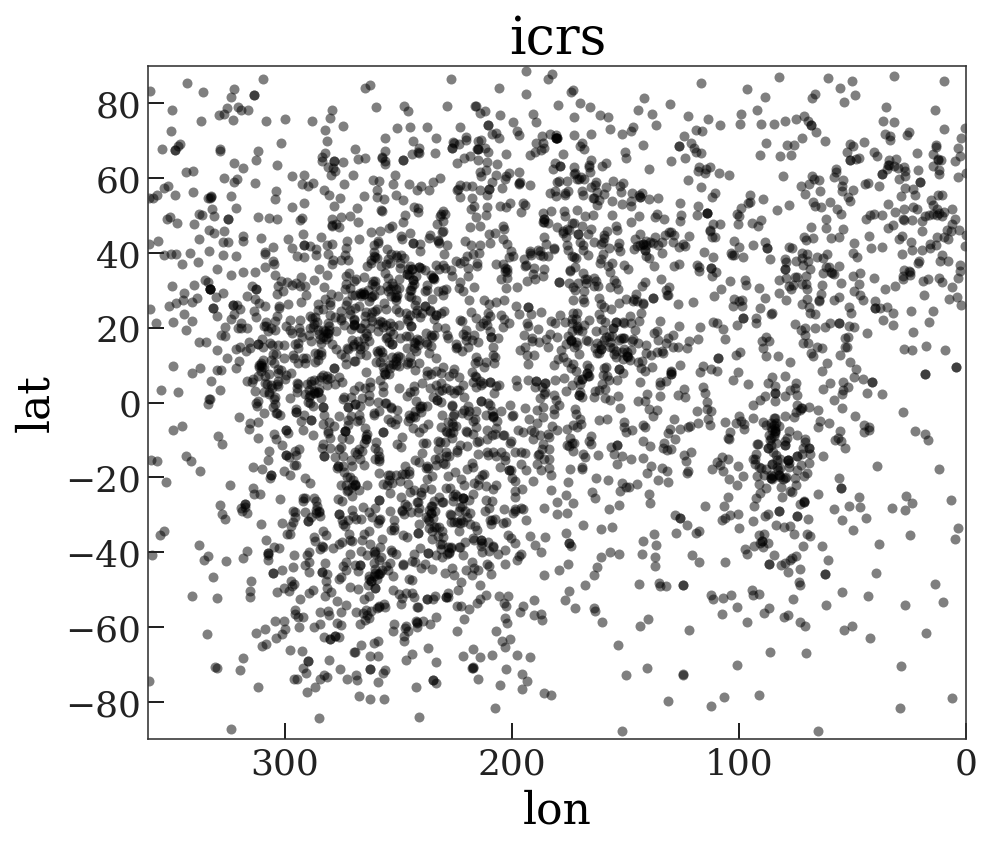

In [57]:
for fr in [coord.BarycentricMeanEcliptic(), coord.Galactic(), coord.ICRS()]:
    fig = plt.figure(figsize=(7, 6))
    plt.scatter(clean_c.transform_to(fr).spherical.lon.degree,
                clean_c.transform_to(fr).spherical.lat.degree,
                alpha=0.5, lw=0)
    plt.xlim(360, 0)
    plt.ylim(-90, 90)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.title(fr.name)
    plt.tight_layout()
    fig.set_facecolor('w')

---

How many brighter stars do we expect?

In [ ]:
from scipy.interpolate import interp1d
from tqdm.notebook import trange
import imf

In [ ]:
iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_-0.1_iso.fits')
i = iso[np.isclose(iso['log10_isochrone_age_yr'], 8.2)] 

fig, ax = make_cmd()
ax.plot(i['G_BP']-i['G_RP'], i['G'])
ax.set_xlim(-1, 3.5)
ax.set_ylim(20, -6)

In [ ]:
iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_-0.1_iso.fits')
i = iso[np.isclose(iso['log10_isochrone_age_yr'], 8.2)] 
i = i[i['phase'] <= 0]  # rgb or before

cluster = imf.make_cluster(10000, massfunc='salpeter')

sim_mags = np.zeros((len(cluster), 3))
for j, f in enumerate(['G', 'G_BP', 'G_RP']):
    interp = interp1d(i['initial_mass'], i[f], kind='cubic', 
                      bounds_error=False)
    sim_mags[:, j] = interp(cluster)
    
sim_mags = sim_mags[np.isfinite(sim_mags[:, 0])]
sim_mags.shape

In [ ]:
glim = (4, 7)
nsim = ((sim_mags[:, 0] > glim[0]) & (sim_mags[:, 0] < glim[1])).sum()
nmg = ((mg.value > glim[0]) & (mg.value < glim[1])).sum()
downsample_fac = int(round(nsim / nmg))
downsample_fac

In [ ]:
#fig, ax = plt.subplots(figsize=(6, 6))

fig, ax = make_cmd()

derp = sim_mags[::downsample_fac]
ax.scatter(derp[:,1]-derp[:,2], derp[:,0], color='tab:blue')

ax.axhspan(glim[0], glim[1], zorder=-100, 
           color='tab:green', alpha=0.2, lw=0)

# ax.set_xlim(-0.5, 3.)
# ax.set_ylim(12, -4)

In [ ]:
counts = {}

for massfunc in ['salpeter', 'kroupa']:
    counts[massfunc] = []
    for trial in trange(1024):
        cluster = imf.make_cluster(10000, massfunc=massfunc)

        sim_mags = np.zeros((len(cluster), 3))
        for j, f in enumerate(['G', 'G_BP', 'G_RP']):
            interp = interp1d(i['initial_mass'], i[f], kind='cubic', 
                              bounds_error=False)
            sim_mags[:, j] = interp(cluster)

        sim_mags = sim_mags[np.isfinite(sim_mags[:, 0])]

        nsim = ((sim_mags[:, 0] > glim[0]) & (sim_mags[:, 0] < glim[1])).sum()
        nmg = ((mg.value > glim[0]) & (mg.value < glim[1])).sum() - 6
        downsample_fac = int(round(nsim / nmg))

        sim_mags = sim_mags[::downsample_fac]
        lim = 6 - coord.Distance(40*u.pc).distmod.value
        counts[massfunc].append((sim_mags[:, 0] < lim).sum())

In [ ]:
fig = plt.figure(figsize=(6, 6))
for k in counts.keys():
    plt.hist(counts[k], bins=np.linspace(0, 50, 32), label=k, alpha=0.5)
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('N stars G < 6 mag')
fig.set_facecolor('w')

---

In [ ]:
g.data[derp_mask].write('../data/TheOGGroup.csv', format='ascii.ecsv', overwrite=True)

In [ ]:
galcen = highprob_c.transform_to(coord.Galactocentric)

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

derp_mask = (galcen.z.to_value(u.pc) > 30)

ax = axes[0]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc)[derp_mask],
           galcen.y.to_value(u.pc)[derp_mask])
ax.set_xlim(-110, 110)
ax.set_ylim(-110, 110)
ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$y$ [pc]')

ax = axes[1]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc)[derp_mask],
           galcen.z.to_value(u.pc)[derp_mask] - galcen.z_sun.to_value(u.pc))

ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$z$ [pc]')

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
vxyz0 = galcen.galcen_v_sun.d_xyz

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

ax = axes[0]
ax.scatter((galcen.v_x - vxyz0[0]).to_value(u.km/u.s),
           (galcen.v_y - vxyz0[1]).to_value(u.km/u.s),
           alpha=0.5, linewidth=0)
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel('$vx$')
ax.set_ylabel('$vy$')

ax = axes[1]
ax.scatter((galcen.v_x - vxyz0[0]).to_value(u.km/u.s),
           (galcen.v_z - vxyz0[2]).to_value(u.km/u.s),
           alpha=0.5, linewidth=0)

ax.set_xlabel('$vx$')
ax.set_ylabel('$vz$')

fig.tight_layout()
fig.set_facecolor('w')

In [ ]:
for x in g.source_id[np.argsort(g.phot_g_mean_mag)][:10]:
    print(f'Gaia DR2 {x}')

xmatch with APOGEE, LAMOST, etc.

In [ ]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta.fits')

In [ ]:
np.isin(g.source_id, allstar['GAIA_SOURCE_ID']).sum()

In [ ]:
_ = make_cmd(color_by=np.isin(g.source_id, allstar['GAIA_SOURCE_ID']),
             color_by_norm=mpl.colors.Normalize(vmin=0, vmax=1),
             color_by_label=f'in APOGEE')

In [ ]:
stars = allstar[np.isin(allstar['GAIA_SOURCE_ID'], g.source_id)]
stars = stars[np.unique(stars['APOGEE_ID'], return_index=True)[1]]

In [ ]:
stars['VSINI']

In [ ]:
stars_100pc = allstar[allstar['GAIA_PARALLAX'] > coord.Distance(100*u.pc).parallax.value]
len(stars_100pc)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['M_H'], stars['ALPHA_M'],
            xerr=stars['M_H_ERR'],
            yerr=stars['ALPHA_M_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['M_H'], stars_100pc['ALPHA_M'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.2, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel('[M/H]')
ax.set_ylabel('[alpha/M]')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['MG_FE'], 
            stars['MN_FE'],
            xerr=stars['MG_FE_ERR'],
            yerr=stars['MN_FE_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['MG_FE'], 
          stars_100pc['MN_FE'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.2, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.2, 0.2)

# ax.set_xlabel('[M/H]')
# ax.set_ylabel('[alpha/M]')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['MG_FE'], 
            stars['AL_FE'],
            xerr=stars['MG_FE_ERR'],
            yerr=stars['AL_FE_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['MG_FE'], 
          stars_100pc['AL_FE'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.4, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.4, 0.2)

ax.set_xlabel('[Mg/Fe]')
ax.set_ylabel('[Al/Fe]')

TODO: xmatch with 2MASS and remake CMD